# Tesco Creative Extension Project

## Table of Contents:
1. [Useful functions](#first-bullet)
    * [Housing](#house)
    * [Income](#income)
    * [Jobs](#jobs)
    * [Community](#community)
    * [Education](#education)
    * [Environment](#env)
    * [Civic Engagement](#civic)
    * [Health](#health)
    * [Life Satisfaction](#satisfaction)
    * [Safety](#safety)
    * [Work-Life Balance](#balance)
    * [Food](#food)
2. [data preprocessing](#second-bullet)

3. [PCA](#3-bullet)

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## useful functions data preprocessing <a class="anchor" id="first-bullet"></a>
in this section we define useful functions to help us in our data preprocessing pipeline:

In [161]:
#Can choose between 'standardize' (xi - mean)/std or 're_scale' (rescales between 0 and 1), also can remove outliers or not
# must be a list though, if remove all outliers just [True] or [False], if some columns yes and others no : [True, False...]
# must match 'columns' lenght. (can be only 1 column) 

def normalize(df,method='standardize', remove_outliers = [True]):
    """function that will allow us to normalize the data, using different methods, and remove outliers (or not).  """
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2
        
    if len(remove_outliers) == 1 :
        remove_outliers = remove_outliers*data.shape[1]
    elif len(remove_outliers) != data.shape[1] : print('Warning, remove_outliers size should match the one of colums')
        
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers[i] :
            #remove outliers
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

In [162]:
# It will happen that we want to inverse some fields in our data sets, to be consistent
def inverse(df, columns = []) :
    if not columns : #if no columns specified apply to all 
        columns =  df.columns[df.columns != 'area_id']
        if 'Names' in df.columns:
            columns = columns[columns != 'Names']
    else : columns = pd.Series(columns)
    for col in columns :
        df.loc[:,col] = 1 - df.loc[:,col]       

    return df

## Data Pre-processing <a class="anchor" id="second-bullet"></a>

In [163]:
#importing the correct data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
ward_total_wellbeing = pd.read_csv('data/total_stats_ward.csv') #serves as validation set (Sort of)

In [164]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna()
ward_demographics = ward_demographics.dropna(axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna()

In [165]:
#rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property, 'foods':ward_tesco}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

We need to create 11 different indicators + 1 with the food. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance

**Housing**

<a class="anchor" id="house"></a>
To create our indicators we need our different categories.
**Housing** : 
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `people_per_sq_km` and we use a way of measuring what types of housing are in the wards : `detached_house`, `semi_detached_house`, `terraced_house` and `apartment`. We are working under the assumption that a house is larger than an apartment and therefore brings less density. 
- need an access to an indoor private flushing toilet --> this is not very pertinent to our dataset. 
- need way of measuring housing expenditure: --> we employ the median house price `median_house_price`


In [166]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names",
                "Median House Price 2014",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

housing.rename(columns={"Median House Price 2014":"median_house_price",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached":"detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached":"semi_detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced":"terraced_house",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment":"apartment"}, inplace=True)

In [167]:
housing = housing.merge(ward_tesco, on='area_id', how='inner')

In [168]:
#keep only wanted rows
column_names = ["area_id","Names","median_house_price","people_per_sq_km","detached_house","semi_detached_house",
               "terraced_house","apartment"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [169]:
#normalize the data by rescaling
housing = normalize(housing, 're_scale',remove_outliers = [True])

In [170]:
#we take the complement of certain values if a higher value indicates a negative influence.
#i.e a higher value for an unemployment rate indicates a "bad" factor. By taking the complement,
#we instead measure the employment rate 
#housing["people_per_sq_km"]= 1-housing["people_per_sq_km"]
housing = inverse(housing, ['people_per_sq_km'])

In [171]:
housing.head(3)

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000026,Abbey,0.0,0.434983,0.105019,0.106040,0.356427,0.460527
1,E05000027,Alibon,0.0,0.628318,0.084301,0.254829,1.000000,0.009179
2,E05000028,Becontree,0.0,0.472386,0.105019,0.385869,0.869302,0.055207


**Income** <a class="anchor" id="income"></a>


link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income

Here we employ the median income of a ward : `median_income` to measure this

In [172]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = income.merge(ward_tesco, on='area_id', how='inner')

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [173]:
#normalize the data by rescaling
income = normalize(income, 're_scale',remove_outliers = [True])

In [174]:
income.head(3) 

,area_id,median_income
0,E05000026,0.212696
1,E05000027,0.154969
2,E05000028,0.176069


**Jobs** <a class="anchor" id="jobs"></a>


link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed : we use the number of incapacity benefit claimants per year to modelise this (`incapacity_claimants`) as well employment and support allowance (ESA) claimants (`esa_claimants`). ESA gives you: 
1. money to help with living costs if you’re unable to work
2. support to get back into work if you’re able to
3. You can apply for ESA if you’re employed, self-employed or unemployed.


* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months) -- we use JSA claiment rates (`jsa_claimants`), which is short for Jobseekers allowance claim, you are eligible if you are actively seeking a job and are of pensionable age. 
* employment rate (`employment_rate_16-64`)

In [175]:
column_names = ['area_id', "Employment rate (16-64) 2011", "Incapacity Benefit Claimants 2014",
               "Employment and support allowance claimants 2014",
                "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)

jobs = jobs.merge(ward_tesco, on='area_id', how='inner')
jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64",
                     "Incapacity Benefit Claimants 2014":'incapacity_claimants',
               "Employment and support allowance claimants 2014": "esa_claimants",
                "JSA Claimant Rate 2015": "jsa_claimants"}, inplace=True)

In [176]:
#normalize the data by rescaling
jobs = normalize(jobs, 're_scale',remove_outliers = [True])

For `incapacity_claimants`, `jsa_claimants` and `esa_claimants`, we want want the data to be consistent with the `emplyoment_rate_16-64` field. The latter is better when high, so we will inverse the former to reflect the fact that more claimants for social programms is better.

In [177]:
jobs = inverse(jobs,['employment_rate_16-64'])
jobs.head(3)

,area_id,employment_rate_16-64,incapacity_claimants,esa_claimants,jsa_claimants
0,E05000026,0.820028,0.322581,0.424559,0.750000
1,E05000027,0.707420,0.580645,0.532589,0.681818
2,E05000028,0.783833,0.516129,0.597407,0.659091


**Community** <a class="anchor" id="community"></a>


link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we do not have the data required for this, so instead we are evaluating the richness of community diversity by 3 factors:

`diversity_ratio` -- which is a measure of the ethnical diversity in a ward. 

`religion_ratio` -- which is a measure of the religious diversity in a ward. 

`no_english_main_language` -- which counts the amount of households who do not have a english-speaker inside it.

In [178]:
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other",
               "Household Language - 2011 Census No people in household have English as a main language",
               "Religion - 2011 Census Christian","Religion - 2011 Census Buddhist","Religion - 2011 Census Hindu",
               "Religion - 2011 Census Jewish","Religion - 2011 Census Muslim","Religion - 2011 Census Sikh", 
               "Religion - 2011 Census Other religions",
                "Religion - 2011 Census No religion"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = community.merge(ward_tesco, on='area_id', how='inner')
community = community[column_names]
community.rename(columns= {"Ethnic Group 5 groups - 2011 Census White":'white', "Ethnic Group 5 groups - 2011 Census Mixed":'mixed', 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British":'asian', 
                           "Ethnic Group 5 groups - 2011 Census Black or Black British":'black',
               "Ethnic Group 5 groups - 2011 Census Other":'other_ethnic',
               "Household Language - 2011 Census No people in household have English as a main language":'no_english_main_language',
               "Religion - 2011 Census Christian":'christian',"Religion - 2011 Census Buddhist":'buddhist',"Religion - 2011 Census Hindu":'hindu',
               "Religion - 2011 Census Jewish":'jewish',"Religion - 2011 Census Muslim":'muslim',"Religion - 2011 Census Sikh":'sikh', 
               "Religion - 2011 Census Other religions":'other',
                "Religion - 2011 Census No religion":'no_religion'},
                 inplace=True)

our diversity ratio is defined as white to all other races. Our religious diversity is defined as the christian and no religion stated to all other religions ratio.

In [179]:
community = community.assign(diversity_ratio = community['white']/
                             (community['mixed']+community['asian']+community['black']+community['other_ethnic']))
community = community.assign(religion_ratio = (community['christian']+community['no_religion'])/
                             (community['buddhist']+community['hindu']+community['jewish']+community['muslim']+
                             community['sikh']+community['other']))

In [180]:
 community = community[['area_id','no_english_main_language','diversity_ratio', 'religion_ratio']]

In [181]:
#normalize the data by rescaling
community = normalize(community, 're_scale',remove_outliers = [True])

#inverse the fiel 'no_english_main_language', as it is difficult to integrate in english society when no one in the household speaks english
community = inverse(community, ['no_english_main_language'])

In [182]:
community.head(3)

,area_id,no_english_main_language,diversity_ratio,religion_ratio
0,E05000026,0.217961,0.017756,0.022245
1,E05000027,0.835578,0.231626,0.498317
2,E05000028,0.737908,0.131520,0.165679


**Education** <a class="anchor" id="education"></a>

link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school `unauthorised_school_abscence`
* student skills -- average performance of student here GCSE `GCSE_score`
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education `higher_education` 

to obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

In [183]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = education.merge(ward_tesco, on='area_id', how='inner')
education = education[column_names]
education = education.assign(higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [184]:
#normalize the data by rescaling
education = normalize(education, 're_scale',remove_outliers = [True])

#unfortunately unauthorised school abscences don't allow for better grade, so we inverse this field 
education = inverse(education, ['unauthorised_school_abscence'])

In [185]:
education.head(3)

,area_id,GCSE_score,unauthorised_school_abscence,higher_education
0,E05000026,0.301296,0.285714,0.333976
1,E05000027,0.168726,0.214286,0.000000
2,E05000028,0.024104,0.214286,0.044121


**Environment** <a class="anchor" id="env"></a>


link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

Here, we do not have a way of measuring the water quality (from the dataset we found), so we are instead measuring other air pollution factors such as :
`PM10_mean` 
`NO2_mean`

additionally, we are assessing the environment quality by observing whether homes have an easy access to nature : `homes_without_access_nature_%` and counting how much of the area in a ward is a greenspace : `area_greenspace` 

In [186]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011','Annual Mean of Nitrogen Dioxide (NO2) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environment = environment.merge(ward_tesco, on='area_id', how='inner')
environment = environment[column_names]


environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_%',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature_%',
                            'Annual Mean of Nitrogen Dioxide (NO2) 2011': 'NO2_mean'},
                 inplace=True)

In [187]:
#normalize the data by rescaling
environment = normalize(environment, 're_scale',remove_outliers = [True])

# only having lots of greenspace is a positive factor, so we inverse the others
#environment = inverse(environment, ['PM10_mean', 'NO2_mean', 'homes_without_access_nature_%'])
environment = inverse(environment, ['area_greenspace_%'])

In [188]:
environment.head(3)

,area_id,PM10_mean,NO2_mean,area_greenspace_%,homes_without_access_nature_%
0,E05000026,0.394537,0.449536,0.721225,0.022053
1,E05000027,0.151745,0.168400,0.740507,0.718725
2,E05000028,0.182094,0.224627,1.000000,0.172414


**Civic Engagement** <a class="anchor" id="civic"></a>


link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections -- modelised by `election_turnout`
* stakeholder engagement for developing regulations -- might be hard to do


In [189]:
#code here
column_names = ['area_id', 'Turnout Borough election 2014' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = civic.merge(ward_tesco, on='area_id', how='inner')
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2014':'election_turnout'}, inplace=True)

In [190]:
#normalize the data by rescaling
civic = normalize(civic, 're_scale',remove_outliers = [True])

In [191]:
civic.head(3)

,area_id,election_turnout
0,E05000026,0.359061
1,E05000027,0.228683
2,E05000028,0.359061


**Health** <a class="anchor" id="health"></a>


link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy -- modeled by `life_expectancy`
* self-reported health (kind of hard) -- modeled by a survey to which people answered if they were in bad health : `people_with_bad_health_percent`

In [192]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = health.merge(ward_tesco, on='area_id', how='inner')
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [193]:
#normalize the data by rescaling
health = normalize(health, 're_scale',remove_outliers = [True])

#We inverse the field people_with_bad_health_percent
health  = inverse(health,['life_expectancy']) 

In [194]:
health.head(3)

,area_id,life_expectancy,people_with_bad_health_percent
0,E05000026,0.524100,0.354167
1,E05000027,0.890177,0.854167
2,E05000028,0.865772,0.916667


**Life Satisfaction** <a class="anchor" id="satisfaction"></a>


link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? -- modelised by the answer to that survey `how_satisfied_are_you_score`

In [195]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = life_satisfaction.merge(ward_tesco, on='area_id', how='inner')
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [196]:
#normalize the data by rescaling
life_satisfaction = normalize(life_satisfaction, 're_scale',remove_outliers = [True])

In [197]:
life_satisfaction.head(3)

,area_id,how_satisfied_are_you_score
0,E05000026,0.748954
1,E05000027,0.330544
2,E05000028,0.497908


**Safety** <a class="anchor" id="safety"></a>


link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) 

Here we use a couple of variables to modelise whether one is feeling safe walking alone at night. We include the counts of theft, robbery, burglary, sexual offence, violence against the person and arsenal rate to modelise this. There are found in the following variables:
`theft_incidents`
`robbery_incidents`
`sexual_offences_incidents`
`violence_against_person_incidents`
`aresenal_incidents`

we also use the `crime_rate` to modelise the homicide rate. 

To answer the question "do you feel safe walking alone at night" we keep the above criminal counts as different categories. We will later combine them if it is significant to do so. 

In [198]:
# code here
column_names = ['area_id', 'Drugs 2014/15', 'Theft and Handling 2014/15',
                'Burglary 2014/15', 'Robbery 2014/15', 'Sexual offences 2014/15', 'Violence against the person 2014/15',
                'Total crime rate 2014/15']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = safety.merge(ward_tesco, on='area_id', how='inner')
safety = safety[column_names]

safety.rename(columns={'Total crime rate 2014/15':'crime_rate',
                      'Drugs 2014/15':'drugs', 'Theft and Handling 2014/15':'theft',
                       'Burglary 2014/15':'burglary', 'Robbery 2014/15':'robbery', 
                       'Sexual offences 2014/15':'sexual_offences', 
                       'Violence against the person 2014/15':'violence_against_person'}, 
              inplace=True)


In [199]:
#normalize the data by rescaling
safety = normalize(safety, 're_scale',remove_outliers = [True])

safety = inverse(safety)

In [200]:
safety.head(3)

,area_id,drugs,theft,burglary,robbery,sexual_offences,violence_against_person,crime_rate
0,E05000026,0.362306,0.509956,0.841418,0.473684,0.138533,0.151468,0.372841
1,E05000027,0.799083,0.936652,0.864113,0.810526,0.557625,0.674364,0.759625
2,E05000028,0.842760,0.881947,0.500993,0.705263,0.557625,0.577299,0.721846


**Work-Life Balance** <a class="anchor" id="balance"></a>


link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

We model this by `part_time_employee_percent`

Here, we will employ the number of part-time employees. This can be used to model how much less time workers spend at work. 

In [201]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = work_life_balance.merge(ward_tesco, on='area_id', how='inner')
work_life_balance = work_life_balance[column_names]

In [202]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             100*work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [203]:
#normalize the data by rescaling
work_life_balance = normalize(work_life_balance, 're_scale',remove_outliers = [True])

In [204]:
work_life_balance.head(3)

,area_id,part_time_employee_percent
0,E05000026,0.444146
1,E05000027,1.000000
2,E05000028,1.000000


**Food** <a class="anchor" id="food"></a>

lastly, we take care of the **food** indicator. We employ the following categories:
- those are the same 8 categories employed in the tesco paper for validation of health outcomes :
1. `energy_tot` which corresponds to the total energy obtained on average
2. `energy_fat` -- the energy obtained from fat-containing foods
3. `energy_sugar` -- the energy obtained from sugar-rich foods
4. `energy_saturate` -- the energy obtaiend from saturated fat foods
5. `energy_protein` -- the energy obtained from protein-rich foods
6. `energy_carb` -- the energy obtained from carb-rich foods
7. `energy_fibre` -- the energy obtained from fiber-rich foods
8. `h_nutrients_calories_norm` -- the normalised food entropy 

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include : `f_beer`, `f_dairy`, `f_eggs`, `f_fish`, `f_fruit_veg`, `f_grains`, `f_meat_red`, `f_poultry`, `f_readymade`,  `f_soft_drinks`, `f_spirits`, `f_sweets`, `f_water`, `f_wine`

In [205]:
column_names = ['area_id','energy_tot','energy_fat','energy_saturate', 'energy_sugar','energy_protein','energy_carb',
                'energy_fibre','h_nutrients_calories_norm', 'f_beer', 'f_dairy', 'f_eggs', 'f_fish', 'f_fruit_veg',
                'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_soft_drinks', 
                'f_spirits', 'f_sweets', 'f_water', 'f_wine' ]
foods = pd.DataFrame(data=master_data["foods"],columns=column_names)

foods = foods.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
foods = foods[column_names]

In [206]:
#normalize the data by rescaling
foods = normalize(foods, 're_scale')

# We know from the paper that proteins, fibers and high food diversity is showing of better food consumption and
# correlates with less food related diseases. We can extrapolate this to inverse the appropiate catergories. 
# For instance we will want to inverse f_readymade, as it is usually high in fats, carbs and sugars, same goes for 
# f_softdrinks or f_sweets. We will also inverse all the alcohol categories

foods = inverse(foods, ['energy_fat','energy_saturate', 'energy_sugar','energy_carb', 'f_beer','f_grains', 
                        'f_readymade', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_wine'])

In [207]:
foods.head(3)

,area_id,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_beer,...,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_soft_drinks,f_spirits,f_sweets,f_water,f_wine
0,E05000026,0.723965,0.232312,0.345773,0.324711,0.284872,0.286711,0.124727,0.108791,0.831028,...,0.270802,0.552684,0.399346,0.418385,0.711412,0.140476,0.325770,0.279024,0.950628,0.969891
1,E05000027,0.777470,0.050601,0.547943,0.463524,0.542319,0.369088,0.177423,0.208612,0.665185,...,0.290615,0.537502,0.607475,0.424397,0.477618,0.342714,0.203186,0.381607,0.881629,0.993365
2,E05000028,0.715080,0.434545,0.472538,0.409495,0.521116,0.233251,0.179997,0.306764,0.866927,...,0.135342,0.388062,0.698553,0.446875,0.572410,0.366215,0.559908,0.300784,0.977995,0.912997


Now, we store all these indicators in a dictionary to easily access them:

In [208]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance, 'Foods':foods}

In [209]:
#Now we need to figure out how to score each indicator 

# PCA - Principal Component Analysis <a class="anchor" id="3-bullet"></a>

In [210]:
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Let's first define a couple of functions that will be very useful

First a function to show heatmaps of correlation

In [211]:
def correlations_heatmap(df) :
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = round(X.shape[1]/1.3)
    
    fig, ax = plt.subplots(figsize=(n,n))  
    sns.heatmap(X.corr(), annot=True, ax=ax, center = 0)
    plt.show()

Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.
The method is based on the approch described by 'Tools for Composite Indicators Building' page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)


In [212]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approch described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.9: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            if component[j] < 0: # skip negative weights
                continue
            weights_matrix[j][i] = component[j]*component[j]/expl_var_array[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

And finaly we will need a function to apply the weights to the values

In [213]:
def calculate_index_for_df(df, weights):
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(Index = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'Index' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

We can now start computing the weights for each category of indicators. Let's start with housing, first we must see if they are correlated at all, if not it doesn't make sens to compute the weights by pca, we would either need to decide ourselves of each weight to give, according to what indicator we deem more important (or simply have equal weights for all of them)

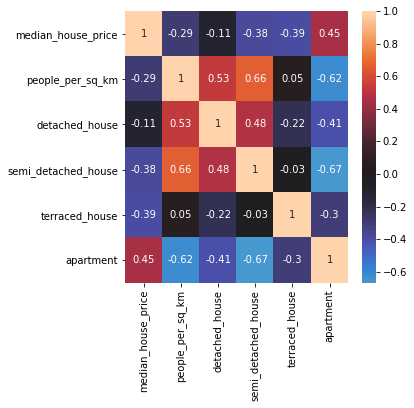

In [214]:
correlations_heatmap(housing)

In [215]:
housing_weights = calculate_weights(housing)

housing_index = calculate_index_for_df(housing,housing_weights )

# Create a df to store the indexes 
indexes = pd.DataFrame(housing_index)
indexes = indexes.rename(columns={'Index' : 'Housing'})

housing_weights

Component cumulative variance: 49.622182566315615 %
Component cumulative variance: 73.87019563517956 %
Component cumulative variance: 82.73816076650719 %
Component cumulative variance: 89.88547205274762 %
Component cumulative variance: 95.76295322015812 %


,weights
median_house_price,0.502728
people_per_sq_km,0.071738
detached_house,1.534007
semi_detached_house,0.074546
terraced_house,0.143294
apartment,0.142535


In [216]:
housing

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000026,Abbey,0.000000,0.434983,0.105019,0.106040,0.356427,0.460527
1,E05000027,Alibon,0.000000,0.628318,0.084301,0.254829,1.000000,0.009179
2,E05000028,Becontree,0.000000,0.472386,0.105019,0.385869,0.869302,0.055207
3,E05000029,Chadwell Heath,0.034712,0.896817,0.084301,0.431185,0.454728,0.153736
4,E05000030,Eastbrook,0.034031,0.892353,0.066440,0.467061,0.669708,0.038581
...,...,...,...,...,...,...,...,...
478,E05000645,Tachbrook,0.681504,0.000000,0.000000,0.000000,0.000000,0.771867
479,E05000646,Vincent Square,0.850774,0.018580,0.000000,0.000000,0.000000,0.882823
480,E05000647,Warwick,0.874256,0.097688,0.000000,0.000000,0.082893,0.777468
481,E05000648,Westbourne,0.387919,0.000000,0.000000,0.000000,0.000000,0.832420


Just from the weights we can already see some interesting things, having a detached house seems to be a big indicator of housing condition. It would make sense as individual houses in london are quite expensive. Median house price is also quite important, with a relatively high weight. It makes sense that the other housing options don't have such high weights, as they can be either in the center of london, where life quality is expected to be quite high, or in very poor suburbs, where we expect lower life quality. The high weigth of `detached_house` could be a problem, as it might overshadow the others, but we can see on the following graph that itst repartition is very much skewed to the left, meaning that only few areas have high density of detached houses. 

(array([161., 156.,  69.,  23.,  16.,  17.,   7.,   6.,   9.,  19.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

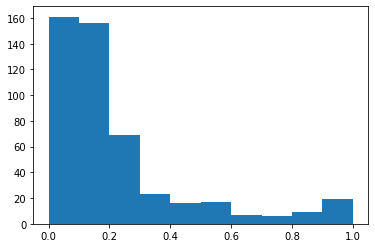

In [217]:
plt.hist(housing.detached_house)

Income, life satisaction, civic and work-life balance are all categories were we only have one sub-indicator, so no need to do any pca analysis. 

In [218]:
for cat in ['Income', 'Life_Satisfaction', 'Civic', 'Work_Life_Balance'] :
    indexes = indexes.merge(meta_data_indicators[cat],on='area_id', how='inner')
indexes =  indexes.rename(columns={'median_income' : 'Income', 'how_satisfied_are_you_score' : 'Life_Satisfaction', 
                                   'election_turnout' : 'Civic', 'part_time_employee_percent' : 'Work_Life_Balance' })


Jobs, community, education, environment and health  all have quite few sub-indicators, so we will perform pca on them, and add the indexes to `indexes`.

Heatmap of correlations for Jobs


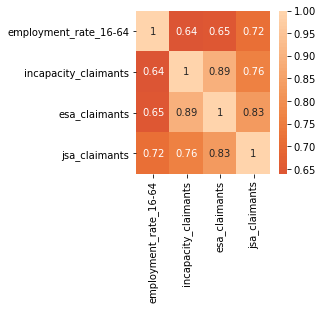

PCA for Jobs
Component cumulative variance: 81.72333800834366 %
Component cumulative variance: 91.96553747416327 %
                        weights
employment_rate_16-64  4.732791
incapacity_claimants   0.132314
esa_claimants          0.139731
jsa_claimants          0.137151
Heatmap of correlations for Community


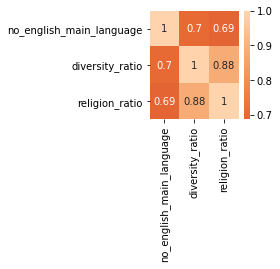

PCA for Community
Component cumulative variance: 83.06245447773772 %
Component cumulative variance: 96.50319187257747 %
                           weights
no_english_main_language  0.225823
diversity_ratio           0.167896
religion_ratio            0.184757
Heatmap of correlations for Education


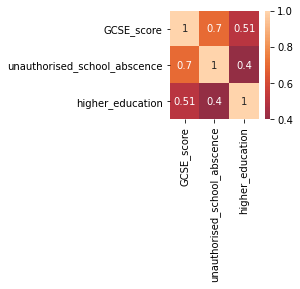

PCA for Education
Component cumulative variance: 68.65973575038761 %
Component cumulative variance: 91.1933012594747 %
                               weights
GCSE_score                    0.212998
unauthorised_school_abscence  0.154147
higher_education              0.211760
Heatmap of correlations for Environment


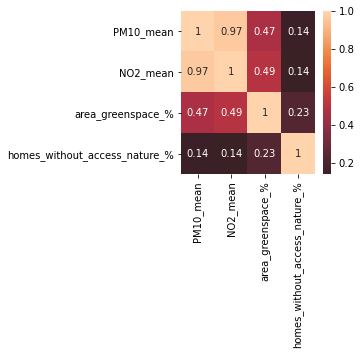

PCA for Environment
Component cumulative variance: 52.87383864250037 %
Component cumulative variance: 84.56957591388593 %
Component cumulative variance: 99.30978779601513 %
                                weights
PM10_mean                      0.140202
NO2_mean                       0.152604
area_greenspace_%              0.126048
homes_without_access_nature_%  3.811745
Heatmap of correlations for Health


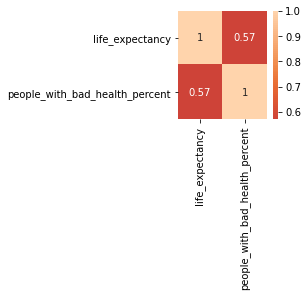

PCA for Health
Component cumulative variance: 78.5664226522844 %
Component cumulative variance: 100.0 %
                                  weights
life_expectancy                  0.376128
people_with_bad_health_percent  11.868935


,area_id,Names,Housing,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health
0,E05000026,Abbey,0.316924,0.212696,0.748954,0.359061,0.444146,4.085891,0.056312,0.178940,0.298885,4.400710
1,E05000027,Alibon,0.337991,0.154969,0.330544,0.228683,1.000000,3.592829,0.319649,0.068970,2.879910,10.472869
2,E05000028,Becontree,0.356187,0.176069,0.497908,0.359061,1.000000,3.951878,0.219328,0.047508,0.843055,11.205498
3,E05000029,Chadwell Heath,0.330320,0.212696,0.079498,0.343416,0.825945,3.447898,0.259308,0.031364,2.491396,10.637523
4,E05000030,Eastbrook,0.319326,0.351242,0.748954,0.343416,0.138427,2.558820,0.362799,0.106797,0.058105,8.485534
...,...,...,...,...,...,...,...,...,...,...,...,...
478,E05000645,Tachbrook,0.452629,0.746974,0.581590,0.390352,0.477835,1.151980,0.243451,0.358103,4.157286,7.779867
479,E05000646,Vincent Square,0.554874,0.715523,0.497908,0.343416,0.019445,2.435203,0.177206,0.298729,1.930415,7.592264
480,E05000647,Warwick,0.569215,0.862827,1.000000,0.286050,0.054814,1.459159,0.215952,0.261303,1.594023,6.520571
481,E05000648,Westbourne,0.313667,0.151784,0.832636,0.113950,0.110907,4.484668,0.051650,0.462488,0.900766,12.235883


In [219]:
for cat in ['Jobs','Community','Education', 'Environment', 'Health']:
    print('Heatmap of correlations for', cat)
    correlations_heatmap(meta_data_indicators[cat])
    print('PCA for', cat)
    weights = calculate_weights(meta_data_indicators[cat])
    index = calculate_index_for_df(meta_data_indicators[cat],weights )
    indexes = indexes.assign(new = index.Index)
    indexes =  indexes.rename(columns={'new' : cat})
    print(weights)
indexes

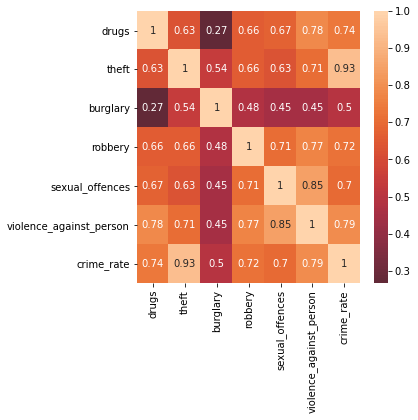

In [220]:
correlations_heatmap(safety)

In [221]:
safety_weights = calculate_weights(safety)
safety_index = calculate_index_for_df(safety, safety_weights)
indexes = indexes.assign(new = safety_index.Index)
indexes =  indexes.rename(columns={'new' : 'Safety'})
safety_weights

Component cumulative variance: 71.06954798004958 %
Component cumulative variance: 81.94842887688348 %
Component cumulative variance: 88.65875348992066 %
Component cumulative variance: 93.78041504036231 %


,weights
drugs,0.007298
theft,0.099220
burglary,0.169701
robbery,0.000000
sexual_offences,3.180269
violence_against_person,0.553339
crime_rate,0.045214


In [222]:
safety_inv = inverse(safety, ['robbery'])
safety_weights = calculate_weights(safety_inv)
safety_index = calculate_index_for_df(safety_inv, safety_weights)
safety_weights

Component cumulative variance: 71.06954798004956 %
Component cumulative variance: 81.94842887688345 %
Component cumulative variance: 88.65875348992066 %
Component cumulative variance: 93.7804150403623 %


,weights
drugs,0.000276
theft,0.003755
burglary,0.006422
robbery,0.410426
sexual_offences,0.120359
violence_against_person,0.020941
crime_rate,0.001711


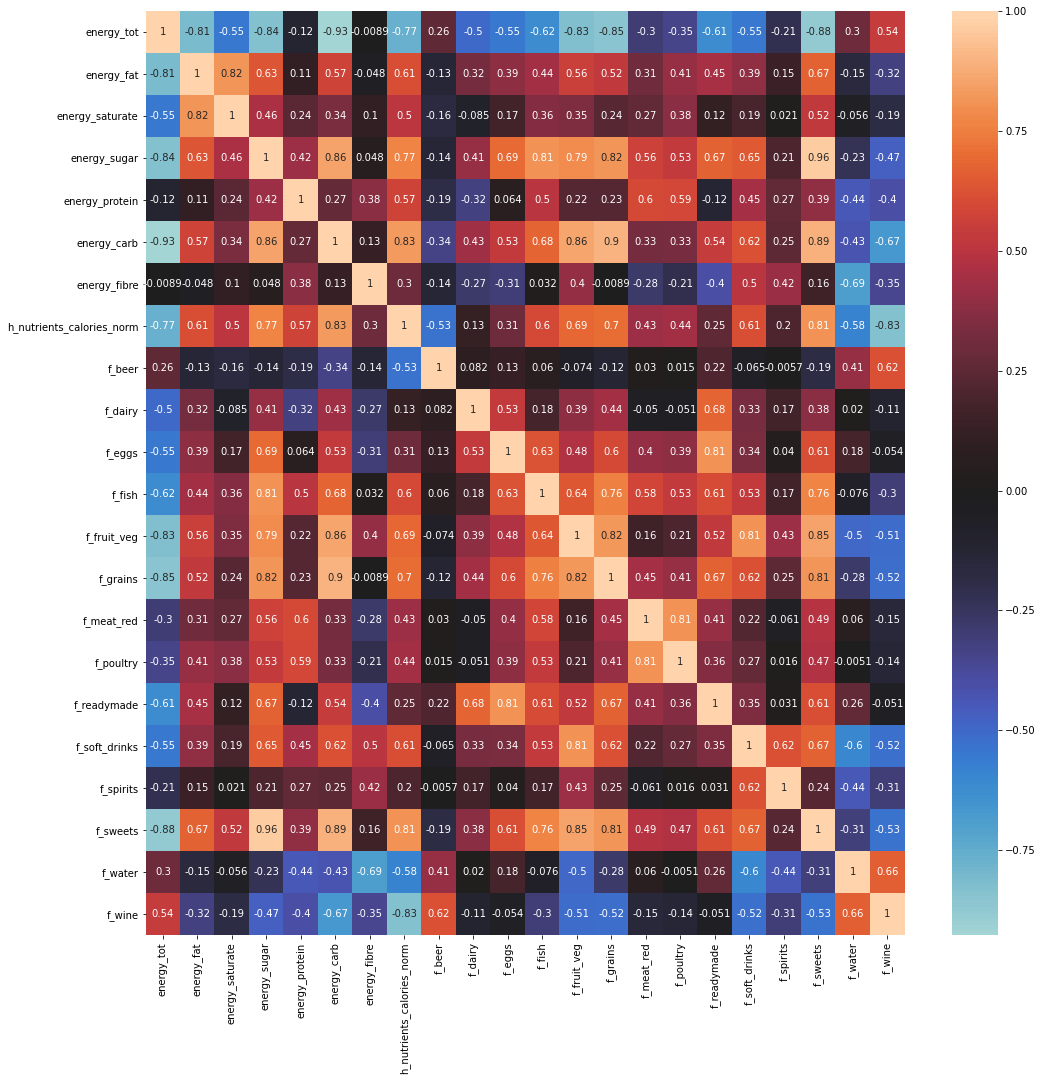

In [223]:
correlations_heatmap(foods)

In [224]:
foods_weights = calculate_weights(foods)
foods_index = calculate_index_for_df(foods, foods_weights)
indexes = indexes.assign(new = safety_index.Index)
indexes =  indexes.rename(columns={'new' : 'Foods'})
foods_weights

Component cumulative variance: 47.071154523612016 %
Component cumulative variance: 64.18801649366615 %
Component cumulative variance: 74.42140255780615 %
Component cumulative variance: 81.55027764235182 %
Component cumulative variance: 86.67835240322874 %
Component cumulative variance: 89.79483018328487 %
Component cumulative variance: 91.75884042151593 %


,weights
energy_tot,0.029189
energy_fat,0.622798
energy_saturate,0.308830
energy_sugar,0.025066
energy_protein,0.058070
energy_carb,0.000000
energy_fibre,0.047305
h_nutrients_calories_norm,0.000000
f_beer,0.129285
f_dairy,0.870466


In [225]:
indexes

,area_id,Names,Housing,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Safety,Foods
0,E05000026,Abbey,0.316924,0.212696,0.748954,0.359061,0.444146,4.085891,0.056312,0.178940,0.298885,4.400710,0.737275,0.243916
1,E05000027,Alibon,0.337991,0.154969,0.330544,0.228683,1.000000,3.592829,0.319649,0.068970,2.879910,10.472869,2.426303,0.169590
2,E05000028,Becontree,0.356187,0.176069,0.497908,0.359061,1.000000,3.951878,0.219328,0.047508,0.843055,11.205498,2.304154,0.208170
3,E05000029,Chadwell Heath,0.330320,0.212696,0.079498,0.343416,0.825945,3.447898,0.259308,0.031364,2.491396,10.637523,2.559803,0.183283
4,E05000030,Eastbrook,0.319326,0.351242,0.748954,0.343416,0.138427,2.558820,0.362799,0.106797,0.058105,8.485534,2.881216,0.182486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,E05000645,Tachbrook,0.452629,0.746974,0.581590,0.390352,0.477835,1.151980,0.243451,0.358103,4.157286,7.779867,3.320841,0.194803
479,E05000646,Vincent Square,0.554874,0.715523,0.497908,0.343416,0.019445,2.435203,0.177206,0.298729,1.930415,7.592264,2.681530,0.183569
480,E05000647,Warwick,0.569215,0.862827,1.000000,0.286050,0.054814,1.459159,0.215952,0.261303,1.594023,6.520571,1.467023,0.236972
481,E05000648,Westbourne,0.313667,0.151784,0.832636,0.113950,0.110907,4.484668,0.051650,0.462488,0.900766,12.235883,2.576296,0.257351


In [226]:
indexes = normalize(indexes, 're_scale', remove_outliers = [False])

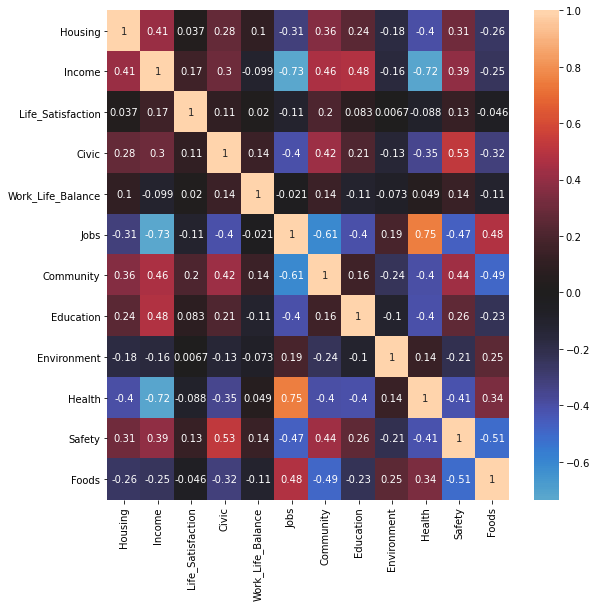

In [227]:
correlations_heatmap(indexes)

In [228]:
indexes = indexes.dropna()
indexes_weigths = calculate_weights(indexes)
final = calculate_index_for_df(indexes, indexes_weigths)
indexes_weigths

Component cumulative variance: 36.93577427539002 %
Component cumulative variance: 48.946436195422436 %
Component cumulative variance: 59.026787535650506 %
Component cumulative variance: 67.77436176652664 %
Component cumulative variance: 74.3563883733737 %
Component cumulative variance: 80.14832010564668 %
Component cumulative variance: 85.12339471283666 %
Component cumulative variance: 89.50615992664379 %
Component cumulative variance: 93.46665196243697 %


,weights
Housing,0.610303
Income,1.658511
Life_Satisfaction,0.161680
Civic,0.846349
Work_Life_Balance,7.568483
Jobs,0.076309
Community,0.376648
Education,0.840928
Environment,5.764832
Health,0.153828


In [229]:
final.to_csv('final.csv', index=False)
final


,area_id,Names,Index
0,E05000026,Abbey,5.646191
1,E05000027,Alibon,12.938904
2,E05000028,Becontree,10.409670
3,E05000029,Chadwell Heath,11.208913
4,E05000030,Eastbrook,3.155647
...,...,...,...
477,E05000644,St. James's,9.824713
478,E05000645,Tachbrook,12.374724
479,E05000646,Vincent Square,5.603661
480,E05000647,Warwick,5.821616


In [151]:
ward_total_wellbeing = ward_total_wellbeing.dropna()


In [152]:
final = final.merge(ward_total_wellbeing, left_on = 'area_id', right_on = 'New ward code' )
final

,area_id,Names,Index,Old Ward Code,New ward code,Ward,Borough,Life Expectancy 2005-2009,Life Expectancy 2006-2010,Life Expectancy 2007-11,...,"Homes with access to open space & nature, and % greenspace - 2009","Homes with access to open space & nature, and % greenspace - 2010","Homes with access to open space & nature, and % greenspace - 2011","Homes with access to open space & nature, and % greenspace - 2012","Homes with access to open space & nature, and % greenspace - 2013","Subjective well-being average score, 2011/12 and 2012/13","Subjective well-being average score, 2011/12 and 2012/13.1","Subjective well-being average score, 2011/12 and 2012/13.2","Subjective well-being average score, 2011/12 and 2012/13.3","Subjective well-being average score, 2013"
0,E05000026,Abbey,5.646191,00ABFX,E05000026,Abbey,Barking and Dagenham,82.1,82.5,82.1,...,-0.9,-0.9,-0.9,-0.9,-0.9,7.9,7.9,7.9,7.9,7.8
1,E05000027,Alibon,12.938904,00ABFY,E05000027,Alibon,Barking and Dagenham,77.8,78.3,78.3,...,-1.8,-1.8,-1.8,-1.8,-1.8,7.4,7.4,7.4,7.4,7.6
2,E05000028,Becontree,10.409670,00ABFZ,E05000028,Becontree,Barking and Dagenham,78.4,78.9,78.7,...,-5.5,-5.5,-5.5,-5.5,-5.5,7.6,7.6,7.6,7.6,7.6
3,E05000029,Chadwell Heath,11.208913,00ABGA,E05000029,Chadwell Heath,Barking and Dagenham,79.9,79.7,80.3,...,2.0,2.0,2.0,2.0,2.0,7.1,7.1,7.1,7.1,7.6
4,E05000030,Eastbrook,3.155647,00ABGB,E05000030,Eastbrook,Barking and Dagenham,77.5,78.1,78.2,...,5.7,5.7,5.7,5.7,5.7,7.9,7.9,7.9,7.9,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,E05000644,St. James's,9.824713,00BKGQ,E05000644,St James's,Westminster,82.8,83.6,83.0,...,8.1,8.1,8.1,8.1,8.1,8.0,8.0,8.0,8.0,8.0
478,E05000645,Tachbrook,12.374724,00BKGR,E05000645,Tachbrook,Westminster,83.5,83.8,83.6,...,7.7,7.7,7.7,7.7,7.7,7.7,7.7,7.7,7.7,8.0
479,E05000646,Vincent Square,5.603661,00BKGS,E05000646,Vincent Square,Westminster,83.1,82.7,82.6,...,9.5,9.5,9.5,9.5,9.5,7.6,7.6,7.6,7.6,8.0
480,E05000647,Warwick,5.821616,00BKGT,E05000647,Warwick,Westminster,83.4,83.4,84.4,...,3.4,3.4,3.4,3.4,3.4,8.2,8.2,8.2,8.2,8.0


In [153]:
data_frames = meta_data_indicators.values()

In [154]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['area_id'], how='outer'), list(data_frames))

In [155]:
df_merged.isnull().sum()

area_id                           0
Names                             0
median_house_price                0
people_per_sq_km                  0
detached_house                    0
semi_detached_house               0
terraced_house                    0
apartment                         0
median_income                     0
employment_rate_16-64             0
incapacity_claimants              0
esa_claimants                     0
jsa_claimants                     0
no_english_main_language          0
diversity_ratio                   0
religion_ratio                    0
GCSE_score                        1
unauthorised_school_abscence      1
higher_education                  1
PM10_mean                         0
NO2_mean                          0
area_greenspace_%                 0
homes_without_access_nature_%     0
election_turnout                  0
life_expectancy                   0
people_with_bad_health_percent    0
how_satisfied_are_you_score       0
drugs                       

In [156]:
df_merged = df_merged.fillna(df_merged.mean())

In [157]:
X = df_merged.loc[:, df_merged.columns != 'area_id']
X = X.loc[:, X.columns != 'Names']


In [158]:
def pca(df) :
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    
    p = PCA()
    X_transformed = p.fit_transform(X)

    eigenvalues = p.explained_variance_

    print("Component 1 Values: {}".format(p.components_[0]))
    i = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        i+=1
        cum_variance += eigenvalue
        print("Component {} : {} - Cumulative Variance: {} %".format(i, eigenvalue, 100*cum_variance/sum_variance))